# Analyze everything

This notebook demonstrates how to run a complete STRESS analysis in a few lines of code and produce all relevant output graphs.

In [1]:
import napari_stress
import napari
import numpy as np
from napari_stress import reconstruction, approximation, measurements, frame_by_frame, TimelapseConverter
import napari_process_points_and_surfaces as nppas
import vedo

from scipy import stats

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

## Config

In [2]:
save_figures_to_dir = True

### Data dimensions
You need to set a few parameters pertaining to your data:

In [3]:
voxel_size_x = 1.0  # microns
voxel_size_y = 1.0  # microns
voxel_size_z = 1.93  # microns
target_voxel_size = 1.0  # microns

### Droplet reconstruction parameters

All of the parameters are explained in more detail [here](point_and_click:droplet_reconstruction).

In [4]:
n_smoothing_iterations = 10
n_points_first_guess = 256
n_tracing_iterations = 1
resampling_length = 1
fit_type = 'fancy'  # can be 'fancy' or 'quick'
edge_type = 'interior'  # can be 'interior' or 'surface'
trace_length = 10
trace_sampling_distance = 0.5

### Stress analysis parameters
All of the used parameters are explained in more detail [here](point_and_click:stress_toolbox).

In [5]:
max_degree = 10  # spherical harmonics degree
n_quadrature_points = 434  # number of quadrature points to measure on
gamma = 6.0  # interfacial tension of droplet

In [6]:
viewer = napari.Viewer(ndisplay=3)

In [7]:
example_data = napari_stress.get_droplet_4d()[0][0]
example_data.shape

(21, 16, 30, 31)

In [8]:
n_frames = example_data.shape[0]

In [9]:
viewer.add_image(example_data)

<Image layer 'example_data' at 0x18f24b78f10>

In [10]:
results_reconstruction = reconstruction.reconstruct_droplet(example_data,
                                                            voxelsize=np.asarray([voxel_size_z, voxel_size_y, voxel_size_x]),
                                                            target_voxelsize=target_voxel_size,
                                                            n_smoothing_iterations=n_smoothing_iterations,
                                                            n_points=n_points_first_guess,
                                                            n_tracing_iterations=n_tracing_iterations,
                                                            resampling_length=resampling_length,
                                                            fit_type=fit_type,
                                                            edge_type=edge_type,
                                                            trace_length=trace_length,
                                                            sampling_distance=trace_sampling_distance
                                                            )

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Processing vertices...: 100%|████████████████████████| 430/430 [00:01<00:00, 409.91it/s]


In [11]:
for res in results_reconstruction:
    if res[2] == 'image':
        viewer.add_image(res[0], **res[1])
    elif res[2] == 'points':
        viewer.add_points(res[0], **res[1])
    elif res[2] == 'vectors':
        viewer.add_vectors(res[0], **res[1])
refined_points = results_reconstruction[3]

We need the refined points to continue:

In [12]:
results_stress_analysis = measurements.comprehensive_analysis(refined_points[0],
                                                              max_degree=max_degree,
                                                              n_quadrature_points=n_quadrature_points,
                                                              gamma=gamma)
for res in results_stress_analysis:
    if res[2] == 'points':
        viewer.add_points(res[0], **res[1])
    if res[2] == 'vectors':
        viewer.add_vectors(res[0], **res[1])

Calculating geodesic distances: 434it [00:01, 317.02it/s]
Calculating geodesic distances: 434it [00:01, 323.66it/s]
Calculating geodesic distances: 434it [00:01, 321.60it/s]
Calculating geodesic distances: 434it [00:01, 306.60it/s]
Calculating geodesic distances: 434it [00:01, 314.14it/s]
Calculating geodesic distances: 434it [00:01, 323.15it/s]
Calculating geodesic distances: 434it [00:01, 306.28it/s]
Calculating geodesic distances: 434it [00:01, 312.01it/s]
Calculating geodesic distances: 434it [00:01, 319.34it/s]
Calculating geodesic distances: 434it [00:01, 320.52it/s]
Calculating geodesic distances: 434it [00:01, 326.80it/s]
Calculating geodesic distances: 434it [00:01, 324.84it/s]
Calculating geodesic distances: 434it [00:01, 319.46it/s]
Calculating geodesic distances: 434it [00:01, 317.71it/s]
Calculating geodesic distances: 434it [00:01, 320.77it/s]
Calculating geodesic distances: 434it [00:01, 322.19it/s]
Calculating geodesic distances: 434it [00:01, 322.19it/s]
Calculating ge

# Visualization

In [32]:
mpl.style.use('default')

In [33]:
for res in results_stress_analysis:
    print(res[1]['name'])

Result of fit spherical harmonics (deg = 10
Result of expand points on ellipsoid
Result of least squares ellipsoid
Result of lebedev quadrature on ellipsoid
Result of lebedev quadrature (droplet)
Extrema total stress
Extrema cell stress
Total stress: Geodesics maxima -> nearest minima
Total stress: Geodesics minima -> nearest maxima
Cell stress: Geodesics maxima -> nearest minima
Cell stress: Geodesics minima -> nearest maxima


## Spherical harmonics

### Fit residue

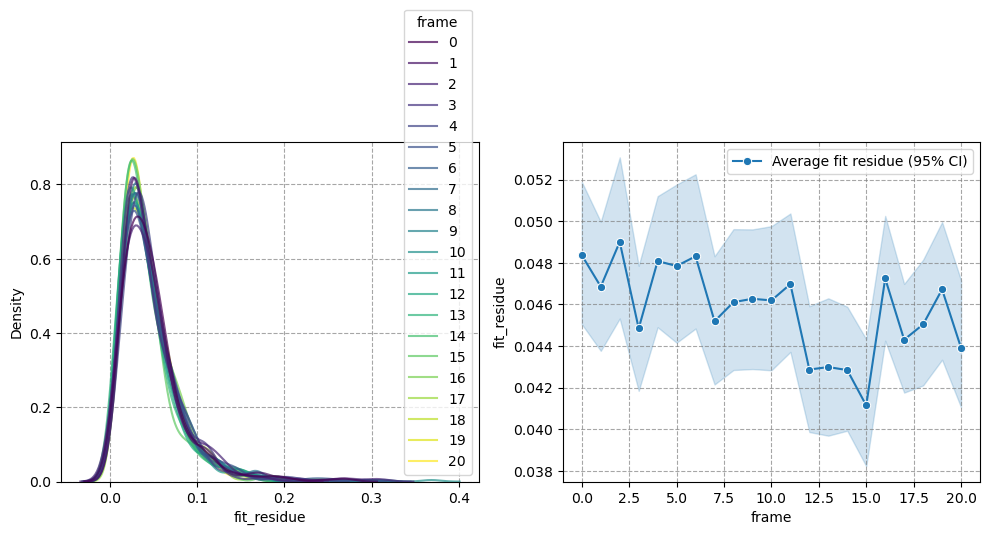

In [34]:
spherical_harmonics_data = results_stress_analysis[0]
df = pd.DataFrame(spherical_harmonics_data[1]['features'])
df['frame'] = spherical_harmonics_data[0][:, 0].astype(int)

fig, axes = plt.subplots(ncols=2, figsize=(10,5))
sns.kdeplot(data=df, x='fit_residue', hue='frame', ax=axes[0], palette='viridis', alpha=0.7)
sns.lineplot(data=df, x='frame', y='fit_residue', ci=95, ax=axes[1], legend=True, label='Average fit residue (95% CI)', marker='o')

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

### Fit quality

In [35]:
lebedev_quadrature_data = results_stress_analysis[4]
df = pd.DataFrame(lebedev_quadrature_data[1]['metadata'])
df['frame'] = np.arange(n_frames).astype(int)

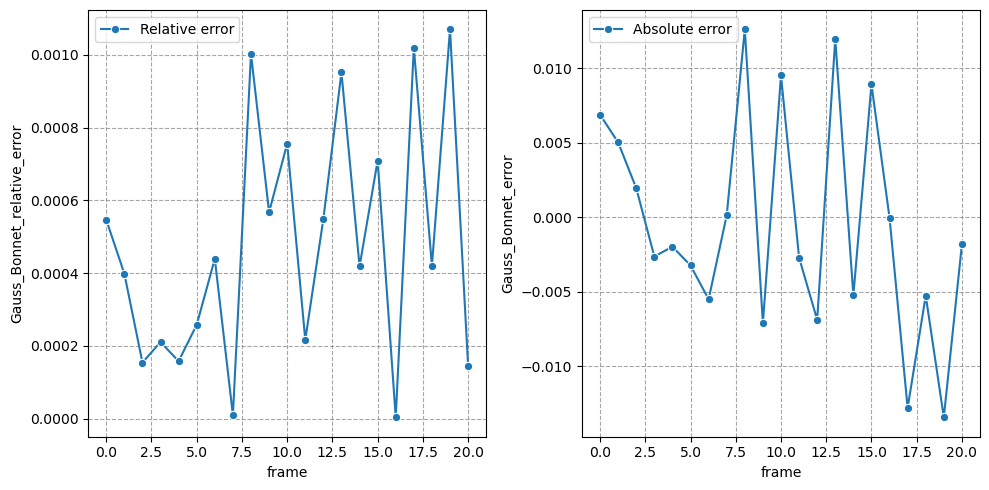

In [36]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
sns.lineplot(data=df, x='frame', y='Gauss_Bonnet_relative_error', legend=True, label='Relative error', marker='o', ax=axes[0])
sns.lineplot(data=df, x='frame', y='Gauss_Bonnet_error', legend=True, label='Absolute error', marker='o', ax=axes[1])

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

## Curvature

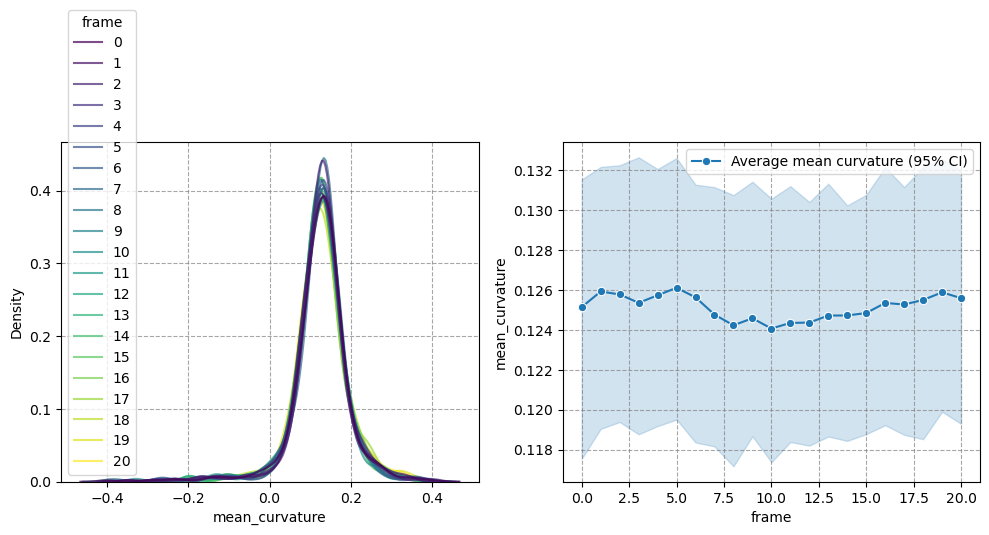

In [37]:
mean_curvature_data = results_stress_analysis[4]

df = pd.DataFrame(mean_curvature_data[1]['features'])
df['frame'] = mean_curvature_data[0][:, 0].astype(int)

fig, axes = plt.subplots(ncols=2, figsize=(10,5))
sns.kdeplot(data=df, x='mean_curvature', hue='frame', ax=axes[0], palette='viridis', alpha=0.7)
sns.lineplot(data=df, x='frame', y='mean_curvature', ci=95, ax=axes[1], legend=True, label='Average mean curvature (95% CI)', marker='o')

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

### Total stress

In [38]:
alpha=0.05

In [39]:
total_anisotropic_stress_data = results_stress_analysis[4]
df = pd.DataFrame(total_anisotropic_stress_data[1]['features'])
df['frame'] = total_anisotropic_stress_data[0][:, 0]

total_stress_anisotropy = []
for t in range(n_frames):
    subset_t = df[df['frame']==t]['anisotropic_stress']
    hist_data = np.histogram(subset_t, bins='auto', density=True)
    hist_dist = stats.rv_histogram(hist_data)
    
    smallest_excluded_value = hist_dist.ppf(alpha)
    largest_excluded_value = hist_dist.ppf(1. - alpha)
    total_stress_anisotropy.append(largest_excluded_value - smallest_excluded_value)

_df = pd.DataFrame(total_stress_anisotropy, columns=['total_stress_anisotropy'])
_df['frame'] = np.arange(n_frames).astype(int)

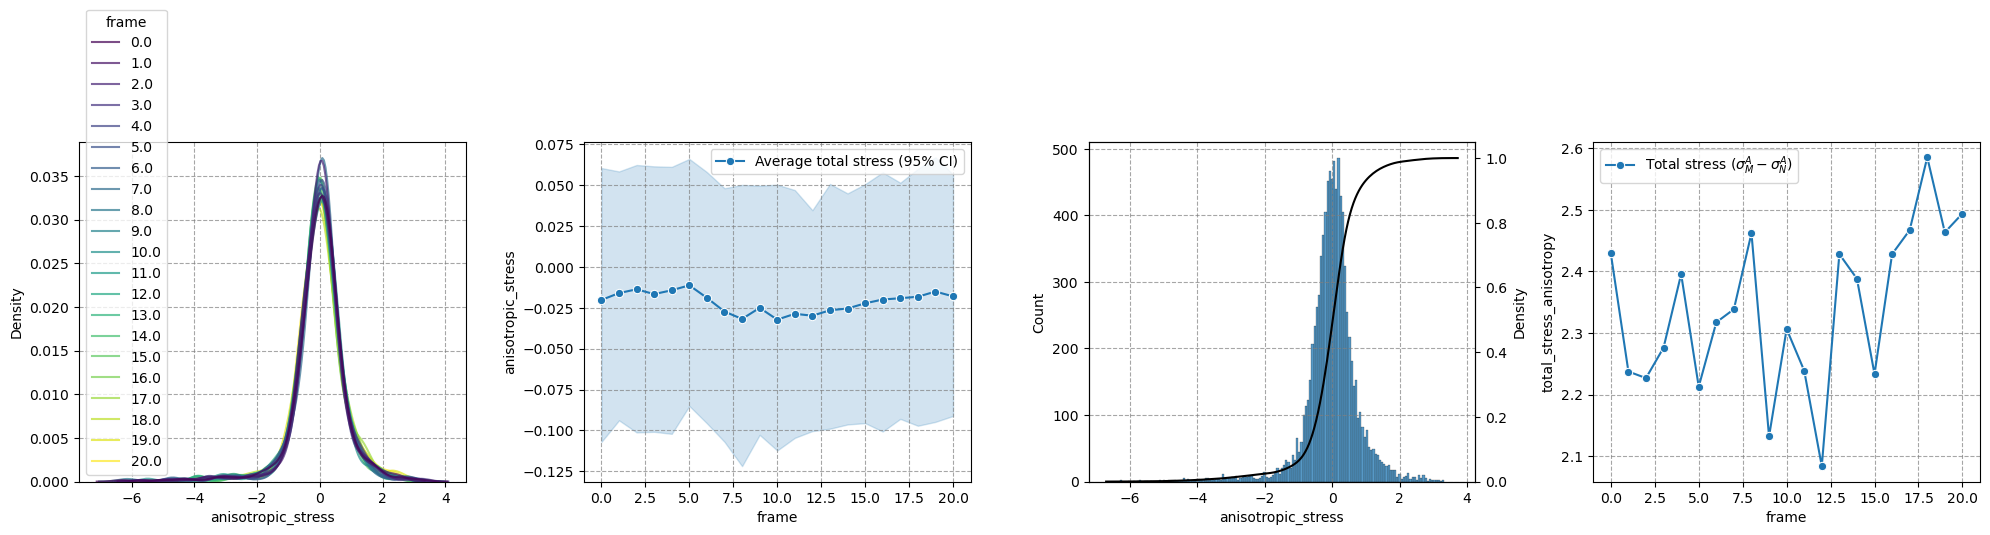

In [40]:
fig, axes = plt.subplots(ncols=4, figsize=(20,5))
_ax2 = axes[2].twinx()
sns.kdeplot(data=df, x='anisotropic_stress', hue='frame', ax=axes[0], palette='viridis', alpha=0.7)
sns.lineplot(data=df, x='frame', y='anisotropic_stress', ci=95, ax=axes[1], legend=True, label='Average total stress (95% CI)', marker='o')
sns.histplot(data=df, x='anisotropic_stress', ax=axes[2], label='Histogram (all frames combined)', legend=True)
sns.kdeplot(data=df, x='anisotropic_stress', ax=_ax2, cumulative=True, label='Cumulative density function (all frames combined)', fill=False, color='black')
sns.lineplot(data=_df, x='frame', y = 'total_stress_anisotropy', label='Total stress ($\sigma^A_M -  \sigma^A_N$)', marker='o', ax=axes[3])

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

### Cell-scale stress

In [41]:
alpha=0.05

In [42]:
total_anisotropic_stress_data = results_stress_analysis[4]
df = pd.DataFrame(total_anisotropic_stress_data[1]['features'])
df['frame'] = total_anisotropic_stress_data[0][:, 0]

cell_stress_anisotropy = []
for t in range(n_frames):
    subset_t = df[df['frame']==t]['anisotropic_stress_cell']
    hist_data = np.histogram(subset_t, bins='auto', density=True)
    hist_dist = stats.rv_histogram(hist_data)
    
    smallest_excluded_value = hist_dist.ppf(alpha)
    largest_excluded_value = hist_dist.ppf(1. - alpha)
    cell_stress_anisotropy.append(largest_excluded_value - smallest_excluded_value)

_df['cell_stress_anisotropy'] = cell_stress_anisotropy

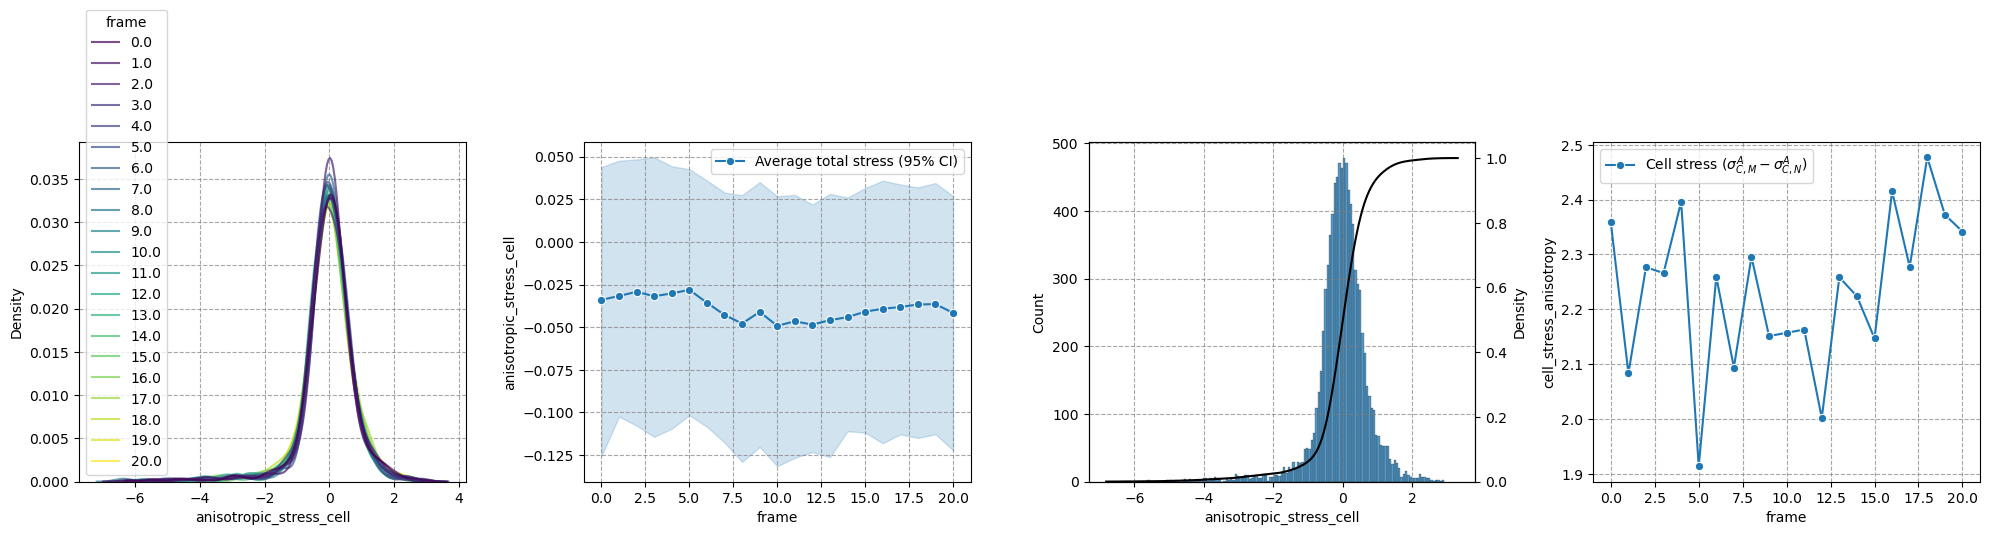

In [43]:
fig, axes = plt.subplots(ncols=4, figsize=(20,5))
_ax2 = axes[2].twinx()
sns.kdeplot(data=df, x='anisotropic_stress_cell', hue='frame', ax=axes[0], palette='viridis', alpha=0.7)
sns.lineplot(data=df, x='frame', y='anisotropic_stress_cell', ci=95, ax=axes[1], legend=True, label='Average total stress (95% CI)', marker='o')
sns.histplot(data=df, x='anisotropic_stress_cell', ax=axes[2], label='Histogram (all frames combined)', legend=True)
sns.kdeplot(data=df, x='anisotropic_stress_cell', ax=_ax2, cumulative=True, label='Cumulative density function (all frames combined)', fill=False, color='black')
sns.lineplot(data=_df, x='frame', y = 'cell_stress_anisotropy', label='Cell stress ($\sigma^A_{C,M} -  \sigma^A_{C,N}$)', marker='o', ax=axes[3])

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

## Tissue-scale stresses

In [52]:
tissue_anisotropic_stress_data = results_stress_analysis[3]
_df['max_tissue_stress_anisotropy'] = tissue_anisotropic_stress_data[1]['metadata']['max_issue_stress_anisotropy']

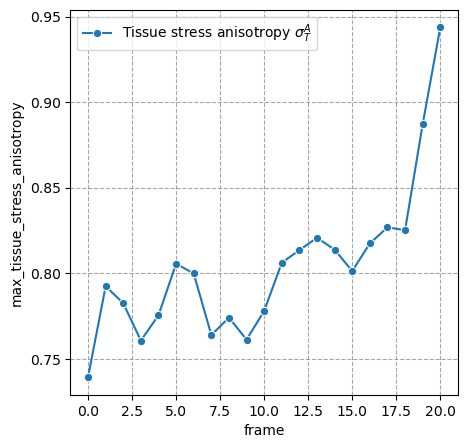

In [47]:
fig, axes = plt.subplots(ncols=1, figsize=(5,5))
sns.lineplot(data=_df, x='frame', y = 'max_tissue_stress_anisotropy', label='Tissue stress anisotropy $\sigma^A_T$', marker='o', ax=axes)
axes.grid(which='major', linestyle='--', color='gray', alpha=0.7)

## Stress along axes

In [60]:
tissue_anisotropic_stress_data = results_stress_analysis[3]
tissue_tensor_elliptical = np.stack(tissue_anisotropic_stress_data[1]['metadata']['Tissue_stress_tensor_elliptical'])
_df['stress_along_e1'] = tissue_tensor_elliptical[:, 0, 0]
_df['stress_along_e2'] = tissue_tensor_elliptical[:, 1, 1]
_df['stress_along_e3'] = tissue_tensor_elliptical[:, 2, 2]
_df['stress_anisotropy_e13'] = _df['stress_along_e1'] - _df['stress_along_e3']
_df['stress_anisotropy_e12'] = _df['stress_along_e1'] - _df['stress_along_e2']
_df['stress_anisotropy_e23'] = _df['stress_along_e2'] - _df['stress_along_e3']

<AxesSubplot: xlabel='frame', ylabel='stress_anisotropy_e13'>

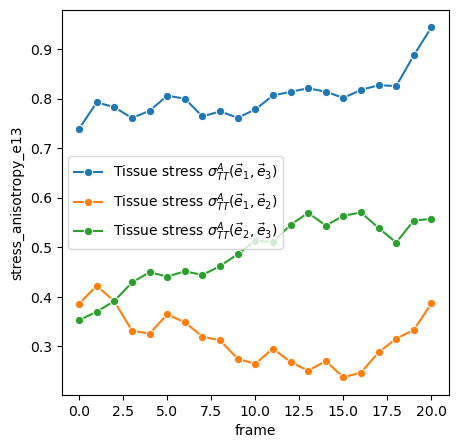

In [61]:
fig, axes = plt.subplots(ncols=1, figsize=(5,5))
sns.lineplot(data=_df, x='frame', y = 'stress_anisotropy_e13', label='Tissue stress $\sigma^A_{TT}(\\vec{e}_1, \\vec{e}_3)$', marker='o', ax=axes)
sns.lineplot(data=_df, x='frame', y = 'stress_anisotropy_e12', label='Tissue stress $\sigma^A_{TT}(\\vec{e}_1, \\vec{e}_2)$', marker='o', ax=axes)
sns.lineplot(data=_df, x='frame', y = 'stress_anisotropy_e23', label='Tissue stress $\sigma^A_{TT}(\\vec{e}_2, \\vec{e}_3)$', marker='o', ax=axes)